**Assignment : Dimensionality Reduction using T-SNE on Amazon Fine Foods Review Dataset**

In [24]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import gensim
import re
import string
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm

In [25]:
con = sqlite3.connect('AmazonReviews.sqlite')
review_dataset = pd.read_sql_query("""select * from reviews where score != '3'""",con)

In [26]:
def partition(data):
    if (data < 3):
        return 'negative'
    else:
        return 'positive'

    
review_score = review_dataset['Score']
positiveNegative = review_score.map(partition)
review_dataset['Score'] = positiveNegative

In [27]:
print(review_dataset.shape)
review_dataset.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [28]:
sorted_data=review_dataset.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)


#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(review_dataset['Id'].size*1.0)*100


(364173, 10)


69.25890143662969

In [29]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)



(364171, 10)


In [30]:
final = final.sort_values('Score', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_positive = final.iloc[-5000:,]
final_negative = final.iloc[:5000:,]
print(final_positive.shape)
print(final_negative.shape)

(5000, 10)
(5000, 10)


In [31]:
final = final_positive.append(final_negative,ignore_index= True)
final = final.sample(frac=1).reset_index(drop=True)

In [32]:
# Data Sampling
#final = final.iloc[:8000,:]

In [33]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

negative    5000
positive    5000
Name: Score, dtype: int64

In [34]:
#nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [35]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [36]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [37]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [38]:
'''final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)'''

"final.head(3) #below the processed review can be seen in the CleanedText Column \n\n\n# store final table into an SQlLite table for future.\nconn = sqlite3.connect('final.sqlite')\nc=conn.cursor()\nconn.text_factory = str\nfinal.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)"

In [39]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 12782)
the number of unique words  12782


In [40]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'food', 2674), (b'like', 2152), (b'love', 2014), (b'tea', 1918), (b'dog', 1782), (b'good', 1775), (b'tast', 1669), (b'great', 1605), (b'product', 1575), (b'one', 1487), (b'use', 1397), (b'flavor', 1341), (b'tri', 1293), (b'get', 1180), (b'cat', 1092), (b'eat', 1072), (b'make', 1067), (b'bag', 972), (b'would', 933), (b'time', 932)]
Most Common Negative Words :  [(b'tast', 3134), (b'like', 3008), (b'product', 2451), (b'flavor', 1960), (b'one', 1734), (b'tri', 1716), (b'would', 1560), (b'tea', 1495), (b'good', 1375), (b'food', 1322), (b'coffe', 1254), (b'get', 1207), (b'use', 1207), (b'buy', 1180), (b'order', 1138), (b'box', 1125), (b'dont', 1036), (b'eat', 1001), (b'even', 993), (b'amazon', 942)]


In [41]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 238945)
the number of unique words including both unigrams and bigrams  238945


In [42]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_counts)
print(standardized_data.shape)
#standardized_data.toarray()

# Standardize Data
standardized_data_bigram = StandardScaler( with_mean=False).fit_transform(final_bigram_counts)
print(standardized_data_bigram.shape)
#standardized_data.toarray()


(10000, 12782)
(10000, 238945)


In [43]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 1000,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

standardized_data_bigram = truncated.fit_transform(standardized_data_bigram)
print(standardized_data_bigram.shape)



(10000, 1000)
(10000, 1000)


In [44]:
def tsne(data,components,perplexity,iterations):
    tic = time.time()
    model = TSNE(n_components= components,random_state=0,perplexity= perplexity,n_iter= iterations)
    tsne_data = model.fit_transform(data)
    toc = time.time()
    #print("TSNE Function executed in: ",toc - tic,' seconds')
    return tsne_data

In [45]:
'''  Function to plot TSNE Model
     Arguments - 
     1. Data - Data on which TSNE will run
     2. Labels - Class Labels
     3. Perplexity = No of Datapoints whose distances should be preserved
     4. Iterations - No of times to iterate to reach optimal output
 
 '''

def plotTSNE(data,labels,perplexity,iterations):
    tsne_df = pd.DataFrame(tsne_data,columns = ('Dim1','Dim2','Label'))
    #plt.title('With perplexity = ',perplexity)
    sns.FacetGrid(tsne_df,hue = ('Label'),height = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.plot()

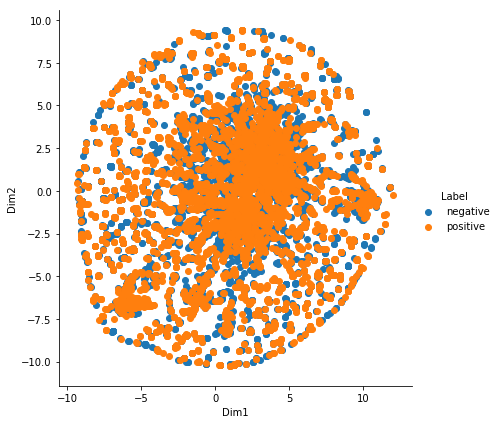

TSNE with perplexity =  2 and iterations = 1000


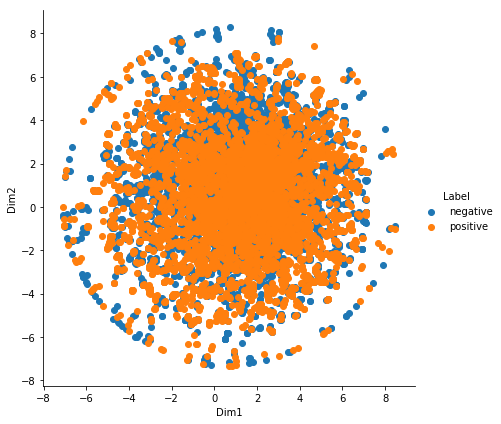

TSNE with perplexity =  20 and iterations = 1000


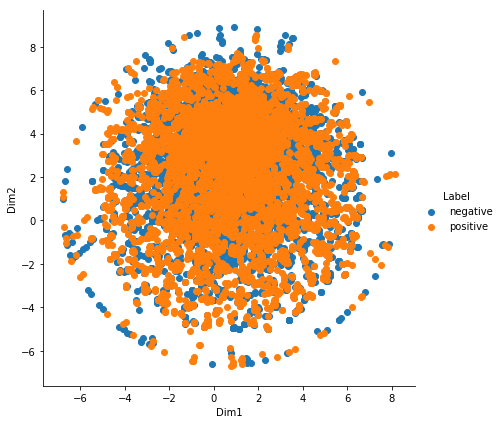

TSNE with perplexity =  30 and iterations = 1000


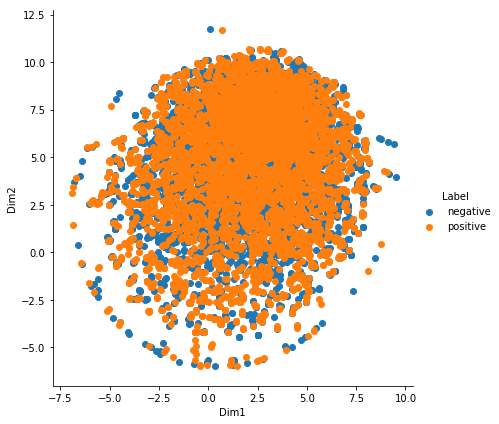

TSNE with perplexity =  50 and iterations = 1000


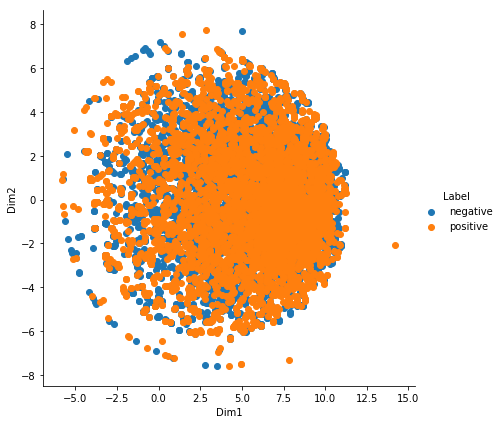

TSNE with perplexity =  80 and iterations = 1000


In [46]:
test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

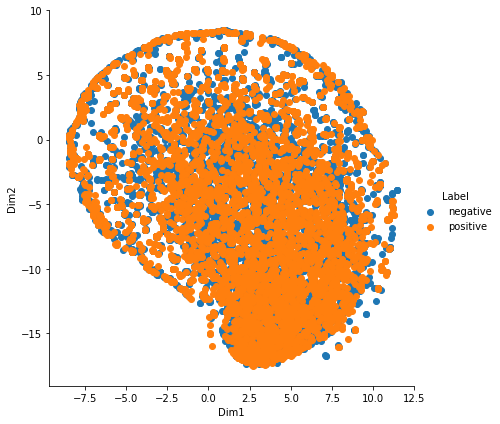

TSNE with perplexity =  2 and iterations = 1000


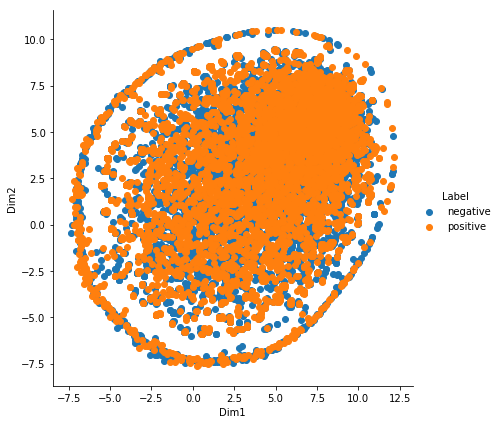

TSNE with perplexity =  20 and iterations = 1000


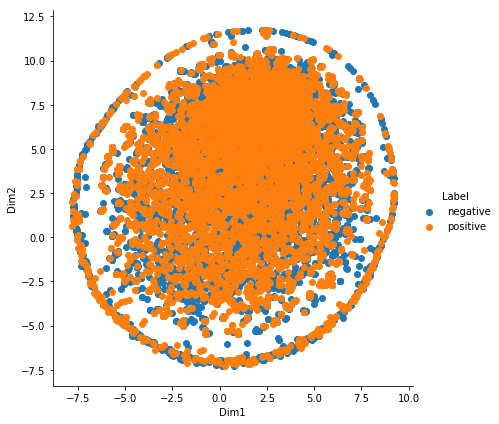

TSNE with perplexity =  30 and iterations = 1000


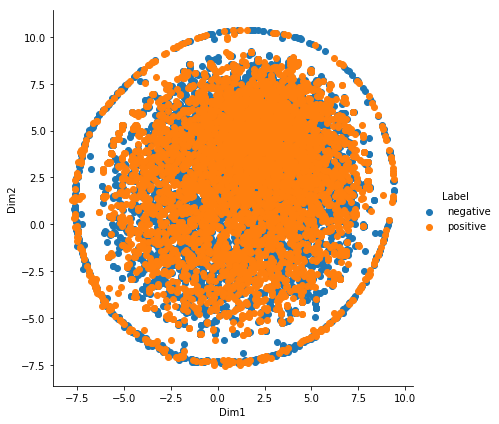

TSNE with perplexity =  50 and iterations = 1000


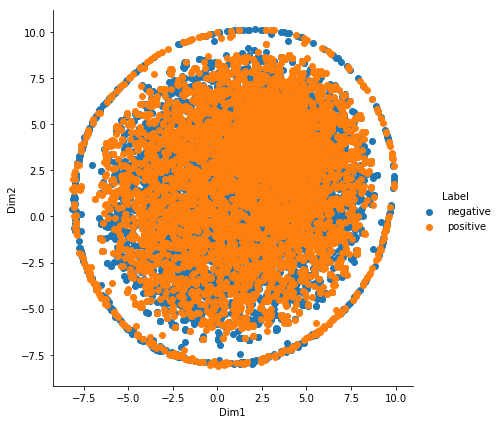

TSNE with perplexity =  80 and iterations = 1000


In [47]:
test_data= standardized_data_bigram
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

In [48]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 238945)
the number of unique words including both unigrams and bigrams  238945


In [49]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_tf_idf)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]

(10000, 238945)


In [50]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

(10000, 100)


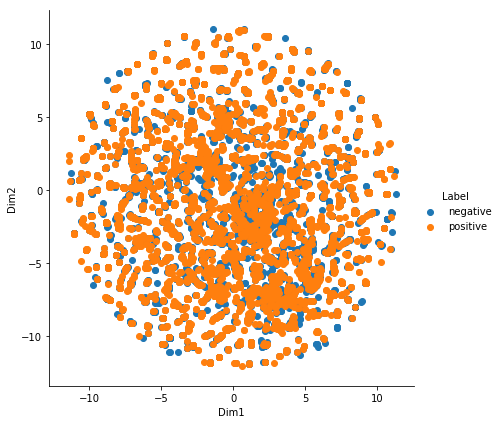

TSNE with perplexity =  2 and iterations = 1000


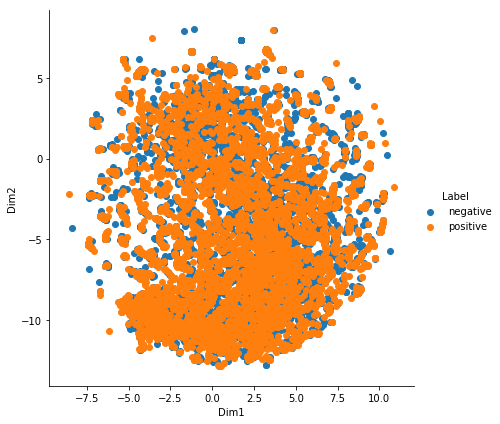

TSNE with perplexity =  20 and iterations = 1000


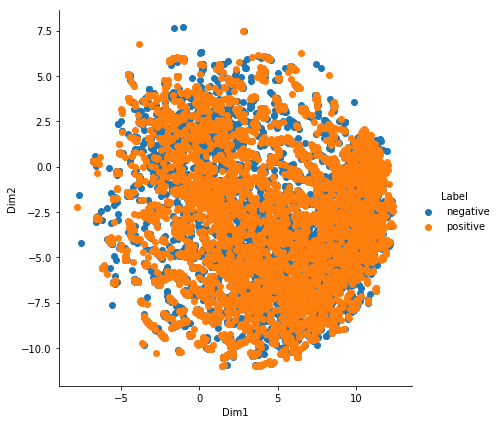

TSNE with perplexity =  30 and iterations = 1000


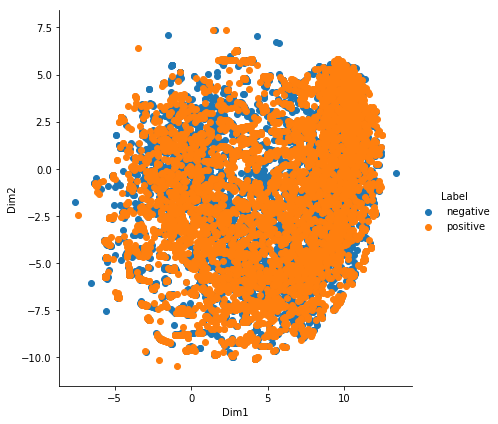

TSNE with perplexity =  50 and iterations = 1000


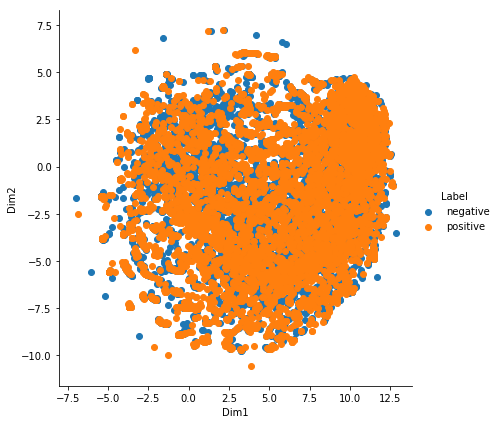

TSNE with perplexity =  80 and iterations = 1000


In [51]:
test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

In [52]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [53]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [54]:
w2v_words = list(w2v_model.wv.vocab)

In [55]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


(10000, 50)


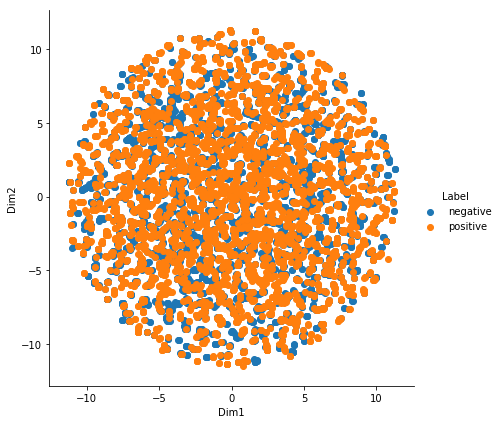

TSNE with perplexity =  2 and iterations = 1000


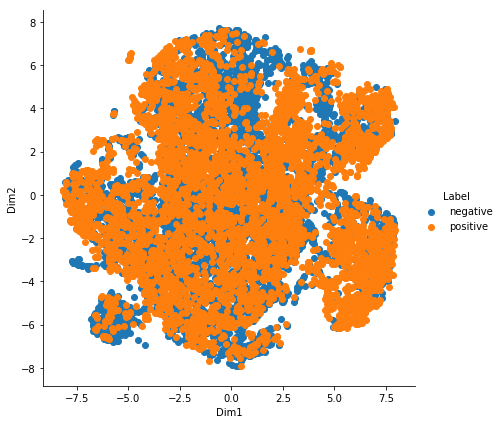

TSNE with perplexity =  20 and iterations = 1000


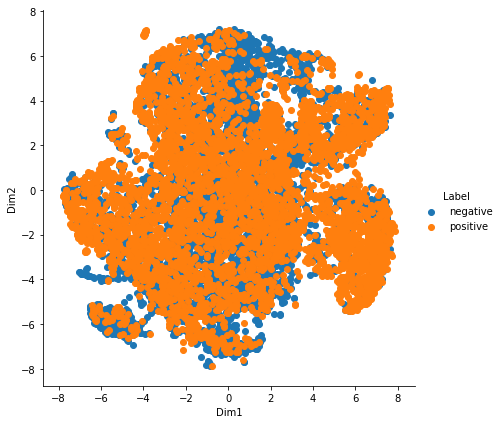

TSNE with perplexity =  30 and iterations = 1000


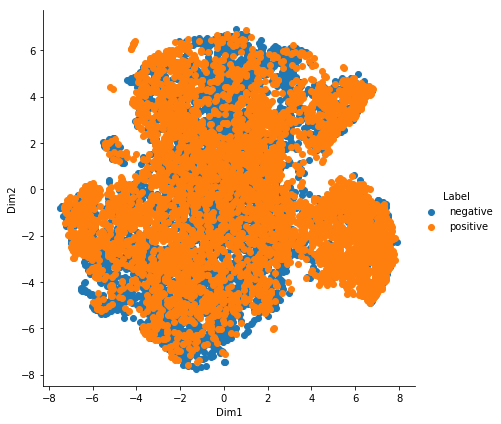

TSNE with perplexity =  50 and iterations = 1000


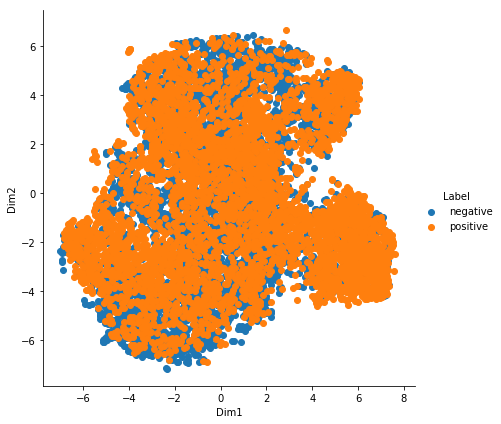

TSNE with perplexity =  80 and iterations = 1000


In [56]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(sent_vectors)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]


'''#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)'''


test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity =  [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

In [57]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names()

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))
#print(tfidf_feat)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(final['CleanedText'].values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:07<00:00, 1331.47it/s]


(10000, 50)


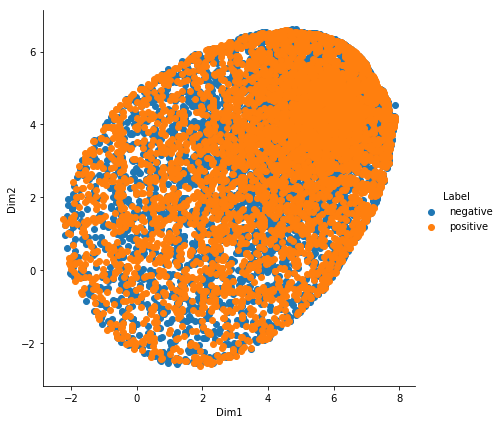

TSNE with perplexity =  2 and iterations = 1000


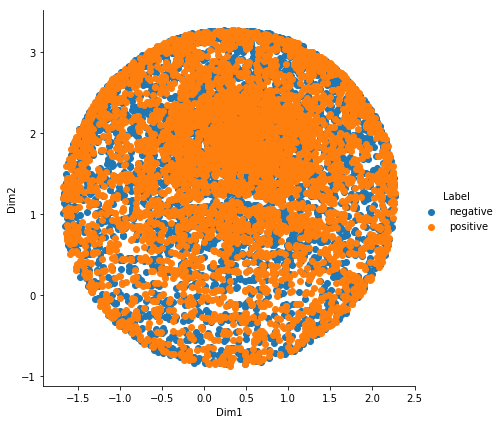

TSNE with perplexity =  20 and iterations = 1000


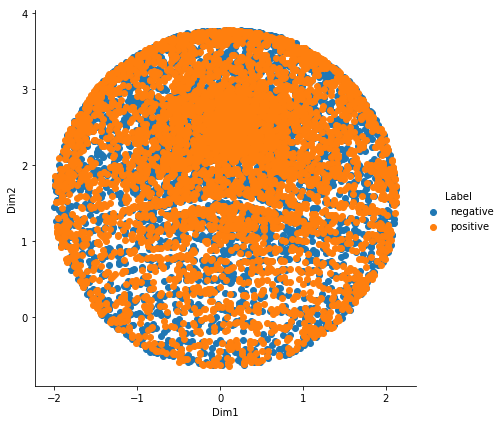

TSNE with perplexity =  30 and iterations = 1000


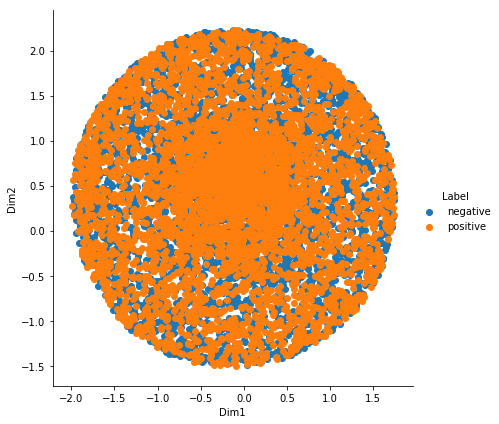

TSNE with perplexity =  50 and iterations = 1000


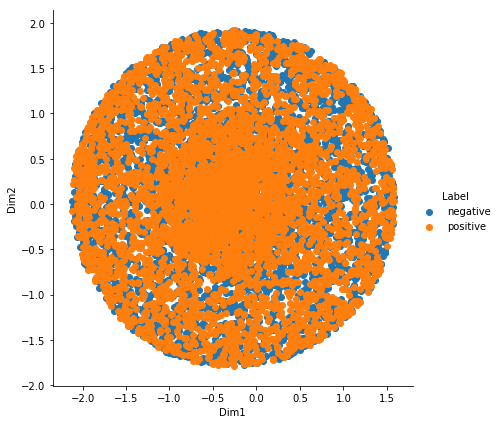

TSNE with perplexity =  80 and iterations = 1000


In [59]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]


'''#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)'''


test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity =  [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 